In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 
import sys
# add parent directory to path
sys.path.append('../')
# Print matplotlib version
import matplotlib as mpl
print('matplotlib: {}'.format(mpl.__version__))
from xgb_gradient_boosted_trees.gradient_boosted_trees import GradientBoostedTreesModel
from xgb_random_forest.random_forest import RandomForestModel
from xgboost import Booster
import xgboost as xgb
from tools.bias_utils import add_demographic_data
import json

matplotlib: 3.7.2


/Users/ebensen/opt/anaconda3/envs/ai_bias/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Load Data

In [2]:
def logit(p):
    return np.log(p/(1-p))

def inv_logit(x):
    return 1/(1+np.exp(-x))

x = 0.99
y = logit(x)
print(y, inv_logit(y))

4.595119850134589 0.99


In [3]:
demographic = 'MINRTY'

In [4]:
demographic = 'MINRTY'

cols_drop = ['Date', 'FC', 'PenRate', 'NumberOfLanes', 'Dir', 'Lat', 'Long']

raw_data_train = pd.read_csv("../data/final_train_data.csv")
raw_data_test = pd.read_csv("../data/final_test_data.csv")
raw_data_test1 = pd.DataFrame(np.concatenate((raw_data_test.values, np.zeros(raw_data_test.shape[0]).reshape(-1, 1)), axis=1),
                                columns = raw_data_test.columns.append(pd.Index(['fold'])))
raw_data = pd.DataFrame(np.concatenate((raw_data_train.values, raw_data_test1.values), axis=0), 
                        columns = raw_data_train.columns)

raw_data = add_demographic_data(raw_data, demographic, loc='../data/off_freeway_station_demographics.csv')
raw_data = raw_data.dropna()
raw_data_train = raw_data.loc[raw_data.fold!=0, :]
raw_data_test = raw_data.loc[raw_data.fold==0, :]
data = raw_data.drop(cols_drop, axis=1)
if 'Dir' in data.columns:
    one_hot = pd.get_dummies(data[['Dir']])
    data = data.drop(['Dir'], axis = 1)
    data = data.join(one_hot)
week_dict = {"DayOfWeek": {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 
                            'Friday': 5, 'Saturday': 6, 'Sunday': 7}}
data = data.replace(week_dict)

X = data.drop(['Volume'], axis=1)
y = data[['Volume']]

X_train = X.loc[X.fold!=0, :]
dem_train = X_train[[demographic]].values
fold_train = X_train[['fold']].values.reshape(-1)
train_ids = X_train[['StationId']].values.reshape((len(X_train), 1))
X_col = X_train.drop(['fold', 'StationId'], axis = 1).columns
X_train = X_train.drop(['fold', 'StationId'], axis = 1).values
y_train = y.loc[X.fold!=0, :].values

X_test = X.loc[X.fold==0, :]
dem_test = X_test[[demographic]].values
test_ids = X_test[['StationId']].values.reshape((len(X_test), 1))
X_test = X_test.drop(['fold', 'StationId'], axis = 1).values
y_test = y.loc[X.fold==0, :].values.flatten()

In [5]:
def to_dmatrix(X, y):
    # get number of columns of np array X
    n_cols = X.shape[1]
    weights = [1.0 for _ in range(n_cols-1)] + [0.0]
    return xgb.DMatrix(X, label=y, feature_weights=weights)

# def r2_score(x,y):
#     return 1 - np.sum((x-y)**2)/np.sum((y-np.mean(y))**2)
def r2_score(x,y):
    x = x.astype(float)
    y = y.astype(float)
    return np.corrcoef(x,y)[0,1]**2

dtrain = to_dmatrix(X_train, y_train)
dtest = to_dmatrix(X_test, y_test)

In [6]:
if not os.path.exists('figures'):
    os.makedirs('figures')
reload = True
model_dict = {'xgb':Booster, 'rf': RandomForestModel, 'gbt': GradientBoostedTreesModel}

In [7]:
demographic = 'MINRTY'
data_file = f'./mitigation_results_{demographic}.csv'
opt_bounds = [0.1, 0.15, 0.25, 1.0, 2.0] # 0.5 and 1.5 are running
models = ['xgb', 'rf', 'gbt']
corrections = ['pearson', 'kendall', 'distance']
cutoffs = [i/10 for i in range(6,10)]

if os.path.exists(data_file) and not reload:
    data = pd.read_csv(data_file)
    # sort by model, correction, opt_boud, cutoff
    data = data.sort_values(by=['model', 'opt_bound', 'correction', 'cutoff'])
    # reset index
    data = data.reset_index(drop=True)
else:
    data = pd.DataFrame()
    cols = ['model', 'correction', 'opt_bound', 'cutoff',
            'r2_0', 'r2_1', 'r2_diff', 'pval', 'fdr_corrected_pval', 'Sig at 0.05',
            'Sig at 0.01', 'Sig at 0.001', 'overall r2', 'mape', 'mae', 'gamma']
    for m in models:
        temp = pd.read_csv(os.path.join('..', 'base_models', m, f'{m}_bias_data.csv'))
        rows = [f'{demographic}_{c}' for c in cutoffs]
        temp = temp[temp['Demographic'].isin(rows)]
        temp['model'] = m
        temp['cutoff'] = cutoffs 
        temp['correction'] = 'none' 
        temp['opt_bound'] = 0.0
        temp['r2_diff'] = temp['r2_0'] - temp['r2_1']
        model = model_dict[m]()
        model.load_model(os.path.join('..', 'base_models', m, f'base_{m}.model'))
        preds = model.predict(dtest).flatten()
        temp['overall r2'] = r2_score(y_test, preds)
        temp['gamma'] = np.sqrt(np.mean((y_test - preds)**2))
        temp['mape'] = np.mean(np.abs((y_test - preds)/y_test))
        temp['mae'] = np.mean(np.abs(y_test - preds))
        temp['gamma'] = 0.0
        temp = temp[cols]
        data = pd.concat([data, temp], axis=0)
        for b in opt_bounds:
            for c in corrections:
                try:
                    temp = pd.read_csv(os.path.join(f'results_{b}', m, c, demographic, 'bias.csv'))
                    model = model_dict[m]()
                    model.load_model(os.path.join(f'results_{b}', m, c, demographic, 'corrected.model'))
                    preds = model.predict(dtest).flatten()
                    gamma_path = os.path.join(f'results_{b}', m, c, demographic, 'gamma_params.json')
                    with open(gamma_path, 'r') as f:
                        gamma_params = json.load(f)
                    temp['gamma'] = 1/(1+np.exp(-gamma_params['correction_gamma']))
                    temp['overall r2'] = r2_score(y_test, preds)
                    temp['rmse'] = np.sqrt(np.mean((y_test - preds)**2))
                    temp['mape'] = np.mean(np.abs((y_test - preds)/y_test))
                    temp['mae'] = np.mean(np.abs(y_test - preds))
                    temp['model'] = m 
                    temp['cutoff'] = cutoffs
                    temp['correction'] = c
                    temp['opt_bound'] = b
                    temp['r2_diff'] = temp['r2_0'] - temp['r2_1']
                    temp = temp[cols]
                    data = pd.concat([data, temp], axis=0)
                except:
                    print(f'No results for {m}, {c}, {b}')
    # sort by model, correction, opt_boud, cutoff
    data = data.sort_values(by=['model', 'mape', 'correction', 'cutoff'])
    # reset index
    data = data.reset_index(drop=True)
    # save to csv
    data.to_csv(data_file, index=False)
baseline = data[data['mape'] == 0.0]
data

No results for rf, distance, 2.0


,model,correction,opt_bound,cutoff,r2_0,r2_1,r2_diff,pval,fdr_corrected_pval,Sig at 0.05,Sig at 0.01,Sig at 0.001,overall r2,mape,mae,gamma
0,gbt,pearson,0.25,0.6,0.914327,0.825303,0.089024,0.0015,0.001500,True,True,False,0.869236,0.871169,50.418385,0.891174
1,gbt,pearson,0.25,0.7,0.913290,0.810302,0.102988,0.0007,0.000933,True,True,True,0.869236,0.871169,50.418385,0.891174
2,gbt,pearson,0.25,0.8,0.906298,0.679277,0.227021,0.0000,0.000000,True,True,True,0.869236,0.871169,50.418385,0.891174
3,gbt,pearson,0.25,0.9,0.903548,0.476748,0.426800,0.0000,0.000000,True,True,True,0.869236,0.871169,50.418385,0.891174
4,gbt,kendall,0.10,0.6,0.918945,0.822755,0.096190,0.0003,0.000300,True,True,True,0.871167,0.875947,50.093106,0.623932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,xgb,distance,1.00,0.9,0.870497,0.529549,0.340948,0.0000,0.000000,True,True,True,0.843558,1.749455,57.976829,0.982587
184,xgb,distance,2.00,0.6,0.427388,0.370356,0.057032,0.0683,0.068300,False,False,False,0.392875,2.649162,126.894270,0.998100
185,xgb,distance,2.00,0.7,0.414501,0.348826,0.065675,0.0321,0.042800,True,False,False,0.392875,2.649162,126.894270,0.998100
186,xgb,distance,2.00,0.8,0.419850,0.268962,0.150888,0.0001,0.000200,True,True,True,0.392875,2.649162,126.894270,0.998100


In [8]:
baseline

,model,correction,opt_bound,cutoff,r2_0,r2_1,r2_diff,pval,fdr_corrected_pval,Sig at 0.05,Sig at 0.01,Sig at 0.001,overall r2,mape,mae,gamma


# Trends

In [9]:
xgb_data = data[data['model'] == 'xgb']
xgb_data = xgb_data.sort_values(by=['opt_bound'])
rf_data = data[data['model'] == 'rf']
rf_data = rf_data.sort_values(by=['opt_bound'])
gbt_data = data[data['model'] == 'gbt']
gbt_data = gbt_data.sort_values(by=['opt_bound'])
data_dict = {'xgb': xgb_data, 'rf': rf_data, 'gbt': gbt_data}

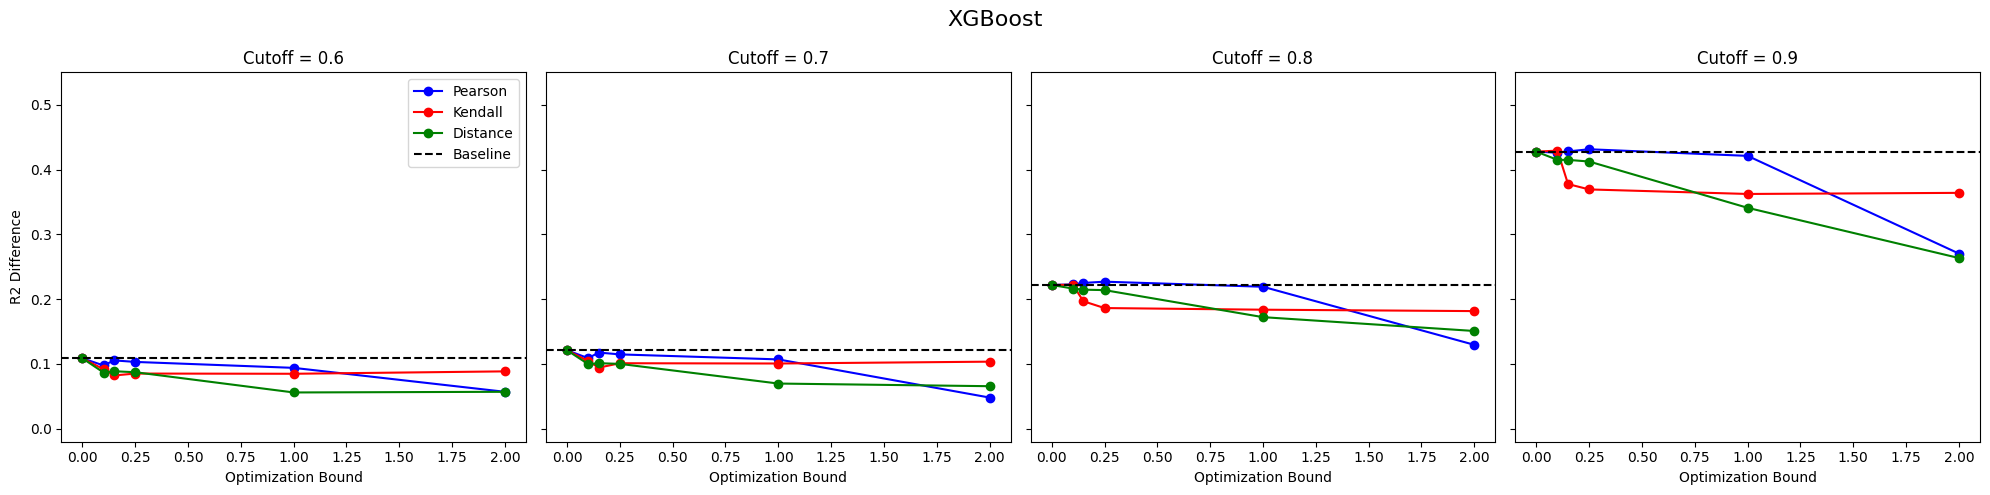

In [10]:
# xgb data plot
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
pearson_inds = (xgb_data['correction'] == 'pearson') | (xgb_data['correction'] == 'none')
kendall_inds = (xgb_data['correction'] == 'kendall') | (xgb_data['correction'] == 'none')
distance_inds = (xgb_data['correction'] == 'distance') | (xgb_data['correction'] == 'none')
inds_6 = xgb_data['cutoff'] == 0.6
inds_7 = xgb_data['cutoff'] == 0.7
inds_8 = xgb_data['cutoff'] == 0.8
inds_9 = xgb_data['cutoff'] == 0.9
ax[0].plot(xgb_data[pearson_inds & inds_6]['opt_bound'], xgb_data[pearson_inds & inds_6]['r2_diff'], label='Pearson', color='blue', marker='o')
ax[1].plot(xgb_data[pearson_inds & inds_7]['opt_bound'], xgb_data[pearson_inds & inds_7]['r2_diff'], color='blue', marker='o')
ax[2].plot(xgb_data[pearson_inds & inds_8]['opt_bound'], xgb_data[pearson_inds & inds_8]['r2_diff'], color='blue', marker='o')
ax[3].plot(xgb_data[pearson_inds & inds_9]['opt_bound'], xgb_data[pearson_inds & inds_9]['r2_diff'], color='blue', marker='o')
ax[0].plot(xgb_data[kendall_inds & inds_6]['opt_bound'], xgb_data[kendall_inds & inds_6]['r2_diff'], label='Kendall', color='red', marker='o')
ax[1].plot(xgb_data[kendall_inds & inds_7]['opt_bound'], xgb_data[kendall_inds & inds_7]['r2_diff'], color='red', marker='o')
ax[2].plot(xgb_data[kendall_inds & inds_8]['opt_bound'], xgb_data[kendall_inds & inds_8]['r2_diff'], color='red', marker='o')
ax[3].plot(xgb_data[kendall_inds & inds_9]['opt_bound'], xgb_data[kendall_inds & inds_9]['r2_diff'], color='red', marker='o')
ax[0].plot(xgb_data[distance_inds & inds_6]['opt_bound'], xgb_data[distance_inds & inds_6]['r2_diff'], label='Distance', color='green', marker='o')
ax[1].plot(xgb_data[distance_inds & inds_7]['opt_bound'], xgb_data[distance_inds & inds_7]['r2_diff'], color='green', marker='o')
ax[2].plot(xgb_data[distance_inds & inds_8]['opt_bound'], xgb_data[distance_inds & inds_8]['r2_diff'], color='green', marker='o')
ax[3].plot(xgb_data[distance_inds & inds_9]['opt_bound'], xgb_data[distance_inds & inds_9]['r2_diff'], color='green', marker='o')
# Plot dotted baseline at initial point
ax[0].axhline(y=xgb_data[inds_6]['r2_diff'].iloc[0], linestyle='--', color='black', label='Baseline')
ax[1].axhline(y=xgb_data[inds_7]['r2_diff'].iloc[0], linestyle='--', color='black')
ax[2].axhline(y=xgb_data[inds_8]['r2_diff'].iloc[0], linestyle='--', color='black')
ax[3].axhline(y=xgb_data[inds_9]['r2_diff'].iloc[0], linestyle='--', color='black')

for a in ax:
    a.set_xlabel('Optimization Bound')
    a.set_ylim(-0.02, 0.55)
ax[0].set_ylabel('R2 Difference')
ax[0].set_title('Cutoff = 0.6')
ax[0].legend()
ax[1].set_title('Cutoff = 0.7')
ax[2].set_title('Cutoff = 0.8')
ax[3].set_title('Cutoff = 0.9')
# Set figure title
fig.suptitle('XGBoost', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('.', 'figures', 'xgb_optimization_bounds.png'), dpi=300, bbox_inches='tight')
plt.show()

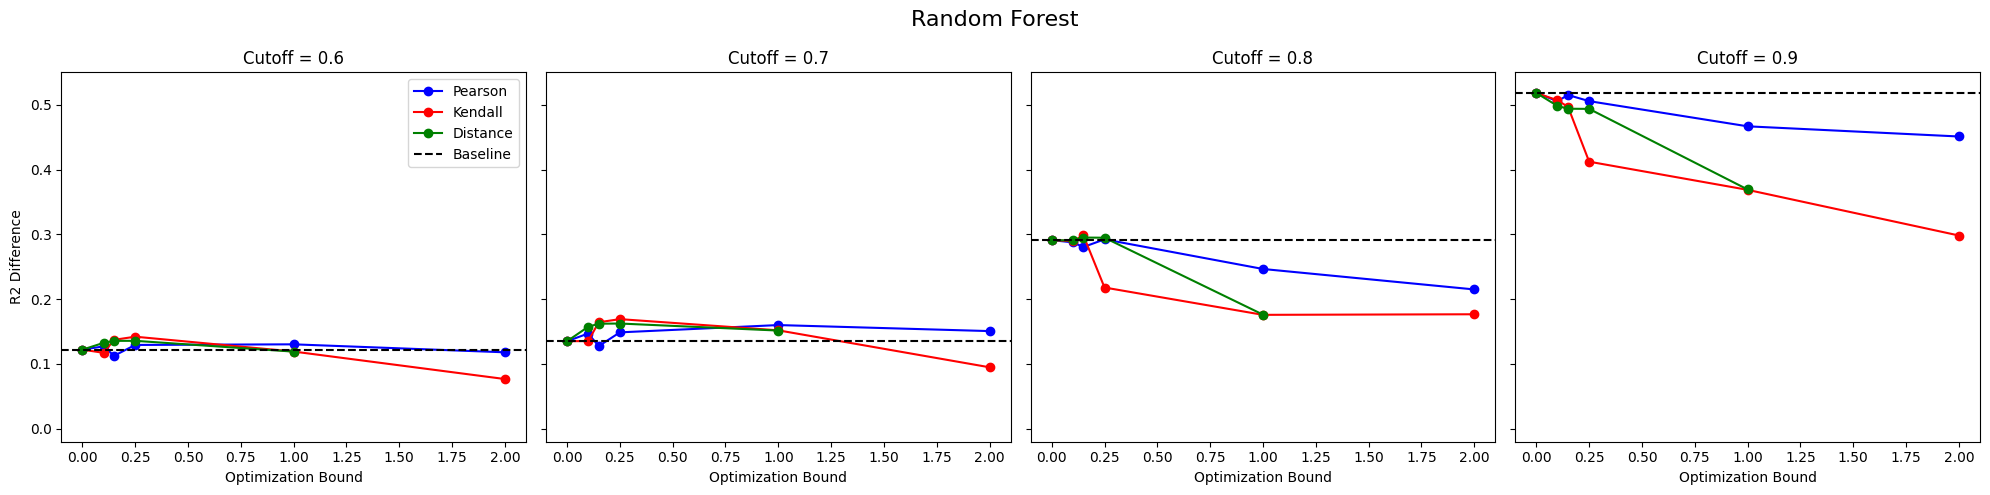

In [11]:
# rf data plot
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
pearson_inds = (rf_data['correction'] == 'pearson') | (rf_data['correction'] == 'none')
kendall_inds = (rf_data['correction'] == 'kendall') | (rf_data['correction'] == 'none')
distance_inds = (rf_data['correction'] == 'distance') | (rf_data['correction'] == 'none')
inds_6 = rf_data['cutoff'] == 0.6
inds_7 = rf_data['cutoff'] == 0.7
inds_8 = rf_data['cutoff'] == 0.8
inds_9 = rf_data['cutoff'] == 0.9
ax[0].plot(rf_data[pearson_inds & inds_6]['opt_bound'], rf_data[pearson_inds & inds_6]['r2_diff'], label='Pearson', color='blue', marker='o')
ax[1].plot(rf_data[pearson_inds & inds_7]['opt_bound'], rf_data[pearson_inds & inds_7]['r2_diff'], color='blue', marker='o')
ax[2].plot(rf_data[pearson_inds & inds_8]['opt_bound'], rf_data[pearson_inds & inds_8]['r2_diff'], color='blue', marker='o')
ax[3].plot(rf_data[pearson_inds & inds_9]['opt_bound'], rf_data[pearson_inds & inds_9]['r2_diff'], color='blue', marker='o')
ax[0].plot(rf_data[kendall_inds & inds_6]['opt_bound'], rf_data[kendall_inds & inds_6]['r2_diff'], label='Kendall', color='red', marker='o')
ax[1].plot(rf_data[kendall_inds & inds_7]['opt_bound'], rf_data[kendall_inds & inds_7]['r2_diff'], color='red', marker='o')
ax[2].plot(rf_data[kendall_inds & inds_8]['opt_bound'], rf_data[kendall_inds & inds_8]['r2_diff'], color='red', marker='o')
ax[3].plot(rf_data[kendall_inds & inds_9]['opt_bound'], rf_data[kendall_inds & inds_9]['r2_diff'], color='red', marker='o')
ax[0].plot(rf_data[distance_inds & inds_6]['opt_bound'], rf_data[distance_inds & inds_6]['r2_diff'], label='Distance', color='green', marker='o')
ax[1].plot(rf_data[distance_inds & inds_7]['opt_bound'], rf_data[distance_inds & inds_7]['r2_diff'], color='green', marker='o')
ax[2].plot(rf_data[distance_inds & inds_8]['opt_bound'], rf_data[distance_inds & inds_8]['r2_diff'], color='green', marker='o')
ax[3].plot(rf_data[distance_inds & inds_9]['opt_bound'], rf_data[distance_inds & inds_9]['r2_diff'], color='green', marker='o')

# Plot dotted baseline at initial point
ax[0].axhline(y=rf_data[inds_6]['r2_diff'].iloc[0], linestyle='--', color='black', label='Baseline')
ax[1].axhline(y=rf_data[inds_7]['r2_diff'].iloc[0], linestyle='--', color='black')
ax[2].axhline(y=rf_data[inds_8]['r2_diff'].iloc[0], linestyle='--', color='black')
ax[3].axhline(y=rf_data[inds_9]['r2_diff'].iloc[0], linestyle='--', color='black')

for a in ax:
    a.set_xlabel('Optimization Bound')
    a.set_ylim(-0.02, 0.55)
ax[0].set_ylabel('R2 Difference')
ax[0].set_title('Cutoff = 0.6')
ax[0].legend()
ax[1].set_title('Cutoff = 0.7')
ax[2].set_title('Cutoff = 0.8')
ax[3].set_title('Cutoff = 0.9')
# Set figure title
fig.suptitle('Random Forest', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('.', 'figures', 'rf_optimization_bounds.png'), dpi=300, bbox_inches='tight')
plt.show()

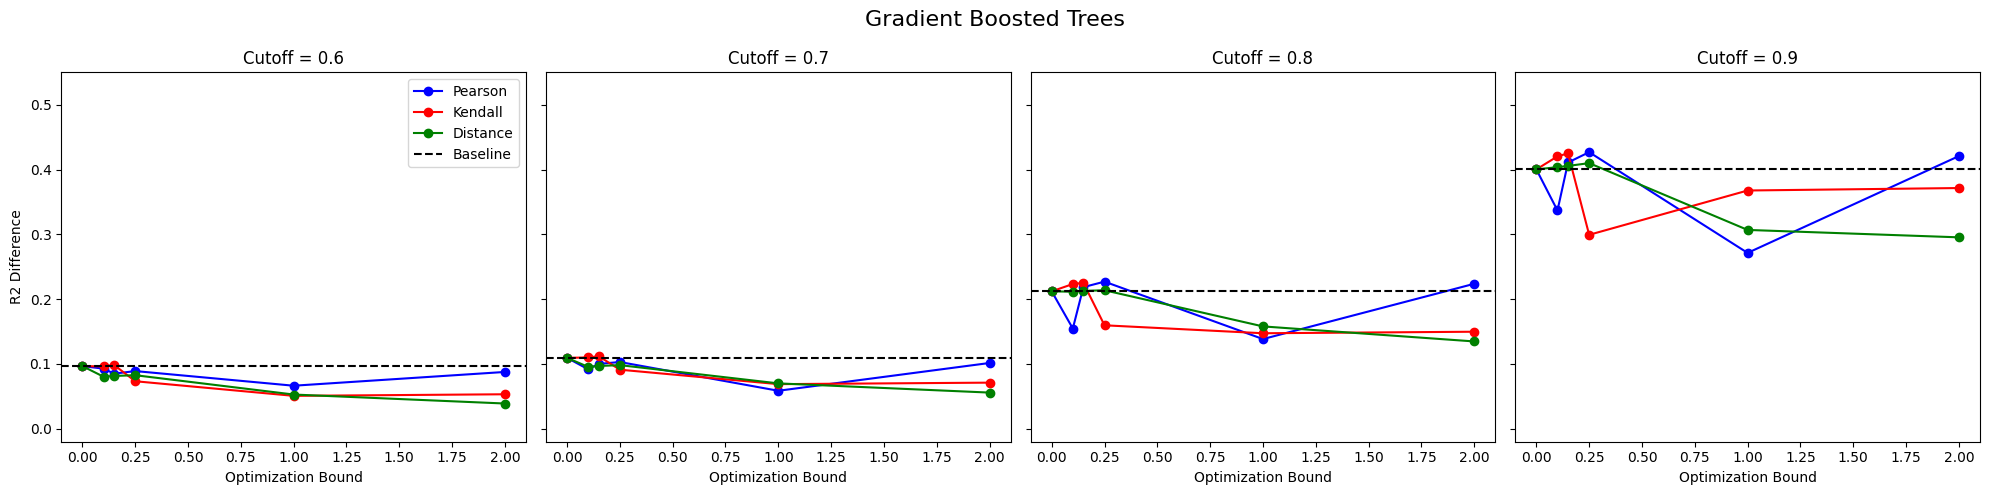

In [12]:
# gbt data plot
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
pearson_inds = (gbt_data['correction'] == 'pearson') | (gbt_data['correction'] == 'none')
kendall_inds = (gbt_data['correction'] == 'kendall') | (gbt_data['correction'] == 'none')
distance_inds = (gbt_data['correction'] == 'distance') | (gbt_data['correction'] == 'none')
inds_6 = gbt_data['cutoff'] == 0.6
inds_7 = gbt_data['cutoff'] == 0.7
inds_8 = gbt_data['cutoff'] == 0.8
inds_9 = gbt_data['cutoff'] == 0.9
ax[0].plot(gbt_data[pearson_inds & inds_6]['opt_bound'], gbt_data[pearson_inds & inds_6]['r2_diff'], label='Pearson', color='blue', marker='o')
ax[1].plot(gbt_data[pearson_inds & inds_7]['opt_bound'], gbt_data[pearson_inds & inds_7]['r2_diff'], color='blue', marker='o')
ax[2].plot(gbt_data[pearson_inds & inds_8]['opt_bound'], gbt_data[pearson_inds & inds_8]['r2_diff'], color='blue', marker='o')
ax[3].plot(gbt_data[pearson_inds & inds_9]['opt_bound'], gbt_data[pearson_inds & inds_9]['r2_diff'], color='blue', marker='o')
ax[0].plot(gbt_data[kendall_inds & inds_6]['opt_bound'], gbt_data[kendall_inds & inds_6]['r2_diff'], label='Kendall', color='red', marker='o')
ax[1].plot(gbt_data[kendall_inds & inds_7]['opt_bound'], gbt_data[kendall_inds & inds_7]['r2_diff'], color='red', marker='o')
ax[2].plot(gbt_data[kendall_inds & inds_8]['opt_bound'], gbt_data[kendall_inds & inds_8]['r2_diff'], color='red', marker='o')
ax[3].plot(gbt_data[kendall_inds & inds_9]['opt_bound'], gbt_data[kendall_inds & inds_9]['r2_diff'], color='red', marker='o')
ax[0].plot(gbt_data[distance_inds & inds_6]['opt_bound'], gbt_data[distance_inds & inds_6]['r2_diff'], label='Distance', color='green', marker='o')
ax[1].plot(gbt_data[distance_inds & inds_7]['opt_bound'], gbt_data[distance_inds & inds_7]['r2_diff'], color='green', marker='o')
ax[2].plot(gbt_data[distance_inds & inds_8]['opt_bound'], gbt_data[distance_inds & inds_8]['r2_diff'], color='green', marker='o')
ax[3].plot(gbt_data[distance_inds & inds_9]['opt_bound'], gbt_data[distance_inds & inds_9]['r2_diff'], color='green', marker='o')

# Plot dotted baseline at initial point
ax[0].axhline(y=gbt_data[inds_6]['r2_diff'].iloc[0], linestyle='--', color='black', label='Baseline')
ax[1].axhline(y=gbt_data[inds_7]['r2_diff'].iloc[0], linestyle='--', color='black')
ax[2].axhline(y=gbt_data[inds_8]['r2_diff'].iloc[0], linestyle='--', color='black')
ax[3].axhline(y=gbt_data[inds_9]['r2_diff'].iloc[0], linestyle='--', color='black')

for a in ax:
    a.set_xlabel('Optimization Bound')
    a.set_ylim(-0.02, 0.55)
ax[0].set_ylabel('R2 Difference')
ax[0].set_title('Cutoff = 0.6')
ax[0].legend()
ax[1].set_title('Cutoff = 0.7')
ax[2].set_title('Cutoff = 0.8')
ax[3].set_title('Cutoff = 0.9')
# Set figure title
fig.suptitle('Gradient Boosted Trees', fontsize=16)
# fig.supylabel('Gradient Boosted Trees', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('.', 'figures', 'gbt_optimization_bounds.png'), dpi=300, bbox_inches='tight')
plt.show()

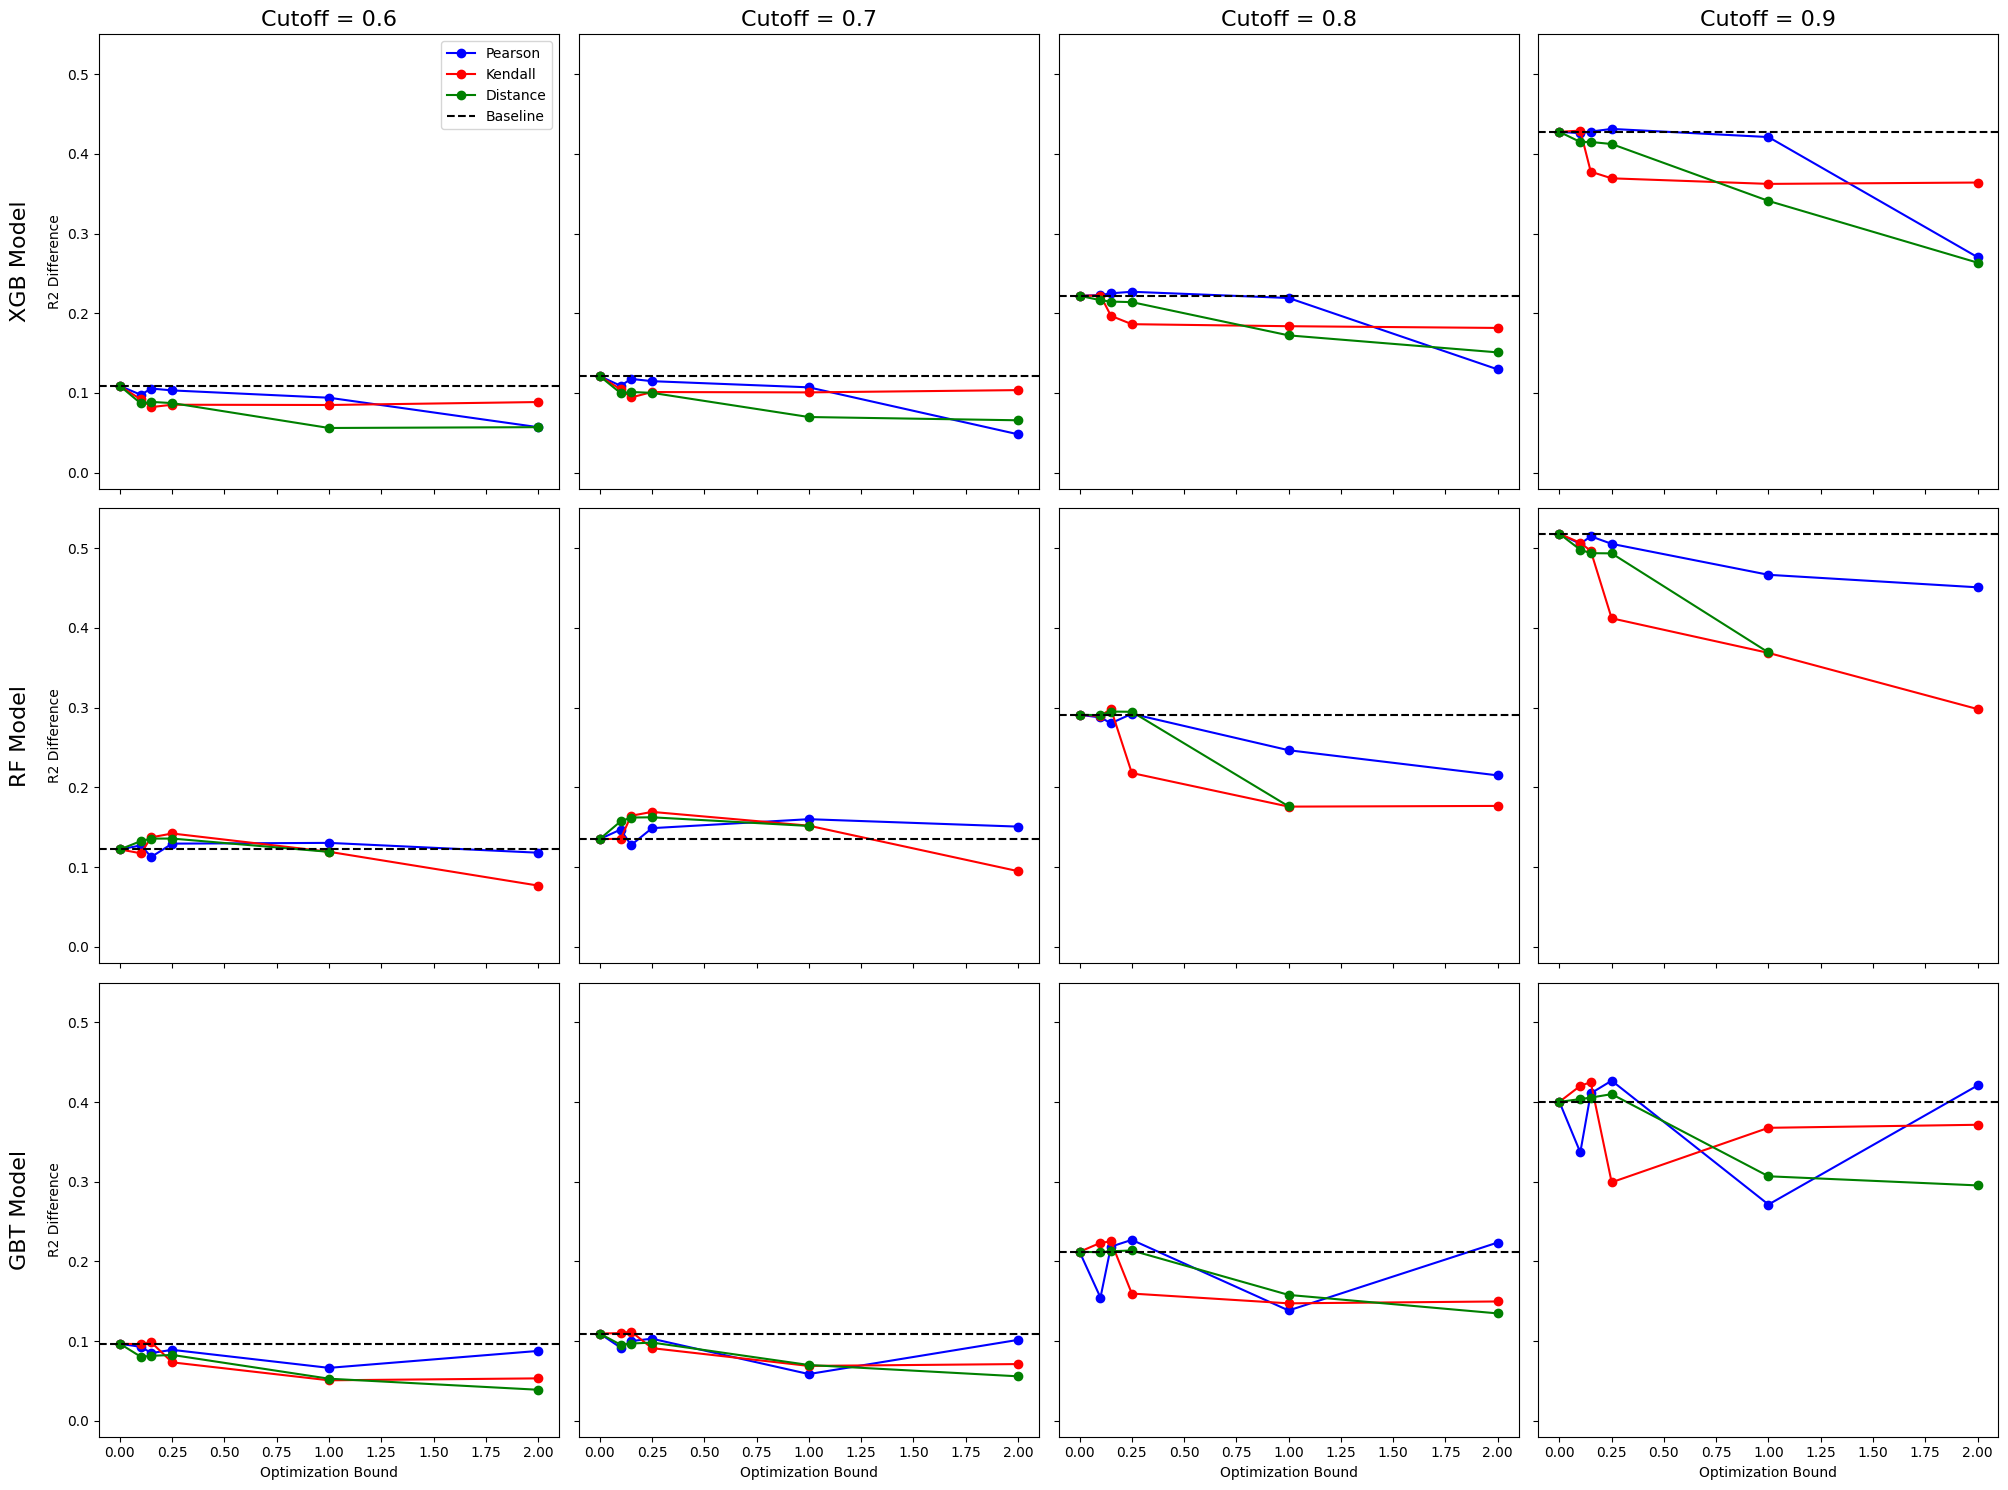

In [13]:
# Stack model xgb, rf, gbt data plot
fig, ax = plt.subplots(3,4, figsize=(20, 15), sharey=True, sharex=True)
#XGB Model
pearson_inds = (xgb_data['correction'] == 'pearson') | (xgb_data['correction'] == 'none')
kendall_inds = (xgb_data['correction'] == 'kendall') | (xgb_data['correction'] == 'none')
distance_inds = (xgb_data['correction'] == 'distance') | (xgb_data['correction'] == 'none')
inds_6 = xgb_data['cutoff'] == 0.6
inds_7 = xgb_data['cutoff'] == 0.7
inds_8 = xgb_data['cutoff'] == 0.8
inds_9 = xgb_data['cutoff'] == 0.9
ax[0,0].plot(xgb_data[pearson_inds & inds_6]['opt_bound'], xgb_data[pearson_inds & inds_6]['r2_diff'], label='Pearson', color='blue', marker='o')
ax[0,1].plot(xgb_data[pearson_inds & inds_7]['opt_bound'], xgb_data[pearson_inds & inds_7]['r2_diff'], color='blue', marker='o')
ax[0,2].plot(xgb_data[pearson_inds & inds_8]['opt_bound'], xgb_data[pearson_inds & inds_8]['r2_diff'], color='blue', marker='o')
ax[0,3].plot(xgb_data[pearson_inds & inds_9]['opt_bound'], xgb_data[pearson_inds & inds_9]['r2_diff'], color='blue', marker='o')
ax[0,0].plot(xgb_data[kendall_inds & inds_6]['opt_bound'], xgb_data[kendall_inds & inds_6]['r2_diff'], label='Kendall', color='red', marker='o')
ax[0,1].plot(xgb_data[kendall_inds & inds_7]['opt_bound'], xgb_data[kendall_inds & inds_7]['r2_diff'], color='red', marker='o')
ax[0,2].plot(xgb_data[kendall_inds & inds_8]['opt_bound'], xgb_data[kendall_inds & inds_8]['r2_diff'], color='red', marker='o')
ax[0,3].plot(xgb_data[kendall_inds & inds_9]['opt_bound'], xgb_data[kendall_inds & inds_9]['r2_diff'], color='red', marker='o')
ax[0,0].plot(xgb_data[distance_inds & inds_6]['opt_bound'], xgb_data[distance_inds & inds_6]['r2_diff'], label='Distance', color='green', marker='o')
ax[0,1].plot(xgb_data[distance_inds & inds_7]['opt_bound'], xgb_data[distance_inds & inds_7]['r2_diff'], color='green', marker='o')
ax[0,2].plot(xgb_data[distance_inds & inds_8]['opt_bound'], xgb_data[distance_inds & inds_8]['r2_diff'], color='green', marker='o')
ax[0,3].plot(xgb_data[distance_inds & inds_9]['opt_bound'], xgb_data[distance_inds & inds_9]['r2_diff'], color='green', marker='o')
# Plot dotted baseline at initial point
ax[0,0].axhline(y=xgb_data[inds_6]['r2_diff'].iloc[0], linestyle='--', color='black', label='Baseline')
ax[0,1].axhline(y=xgb_data[inds_7]['r2_diff'].iloc[0], linestyle='--', color='black')
ax[0,2].axhline(y=xgb_data[inds_8]['r2_diff'].iloc[0], linestyle='--', color='black')
ax[0,3].axhline(y=xgb_data[inds_9]['r2_diff'].iloc[0], linestyle='--', color='black')

#RF Model
pearson_inds = (rf_data['correction'] == 'pearson') | (rf_data['correction'] == 'none')
kendall_inds = (rf_data['correction'] == 'kendall') | (rf_data['correction'] == 'none')
distance_inds = (rf_data['correction'] == 'distance') | (rf_data['correction'] == 'none')
inds_6 = rf_data['cutoff'] == 0.6
inds_7 = rf_data['cutoff'] == 0.7
inds_8 = rf_data['cutoff'] == 0.8
inds_9 = rf_data['cutoff'] == 0.9
ax[1,0].plot(rf_data[pearson_inds & inds_6]['opt_bound'], rf_data[pearson_inds & inds_6]['r2_diff'], label='Pearson', color='blue', marker='o')
ax[1,1].plot(rf_data[pearson_inds & inds_7]['opt_bound'], rf_data[pearson_inds & inds_7]['r2_diff'], color='blue', marker='o')
ax[1,2].plot(rf_data[pearson_inds & inds_8]['opt_bound'], rf_data[pearson_inds & inds_8]['r2_diff'], color='blue', marker='o')
ax[1,3].plot(rf_data[pearson_inds & inds_9]['opt_bound'], rf_data[pearson_inds & inds_9]['r2_diff'], color='blue', marker='o')
ax[1,0].plot(rf_data[kendall_inds & inds_6]['opt_bound'], rf_data[kendall_inds & inds_6]['r2_diff'], label='Kendall', color='red', marker='o')
ax[1,1].plot(rf_data[kendall_inds & inds_7]['opt_bound'], rf_data[kendall_inds & inds_7]['r2_diff'], color='red', marker='o')
ax[1,2].plot(rf_data[kendall_inds & inds_8]['opt_bound'], rf_data[kendall_inds & inds_8]['r2_diff'], color='red', marker='o')
ax[1,3].plot(rf_data[kendall_inds & inds_9]['opt_bound'], rf_data[kendall_inds & inds_9]['r2_diff'], color='red', marker='o')
ax[1,0].plot(rf_data[distance_inds & inds_6]['opt_bound'], rf_data[distance_inds & inds_6]['r2_diff'], label='Distance', color='green', marker='o')
ax[1,1].plot(rf_data[distance_inds & inds_7]['opt_bound'], rf_data[distance_inds & inds_7]['r2_diff'], color='green', marker='o')
ax[1,2].plot(rf_data[distance_inds & inds_8]['opt_bound'], rf_data[distance_inds & inds_8]['r2_diff'], color='green', marker='o')
ax[1,3].plot(rf_data[distance_inds & inds_9]['opt_bound'], rf_data[distance_inds & inds_9]['r2_diff'], color='green', marker='o')

# Plot dotted baseline at initial point
ax[1,0].axhline(y=rf_data[inds_6]['r2_diff'].iloc[0], linestyle='--', color='black', label='Baseline')
ax[1,1].axhline(y=rf_data[inds_7]['r2_diff'].iloc[0], linestyle='--', color='black')
ax[1,2].axhline(y=rf_data[inds_8]['r2_diff'].iloc[0], linestyle='--', color='black')
ax[1,3].axhline(y=rf_data[inds_9]['r2_diff'].iloc[0], linestyle='--', color='black')

#GBT Model
pearson_inds = (gbt_data['correction'] == 'pearson') | (gbt_data['correction'] == 'none')
kendall_inds = (gbt_data['correction'] == 'kendall') | (gbt_data['correction'] == 'none')
distance_inds = (gbt_data['correction'] == 'distance') | (gbt_data['correction'] == 'none')
inds_6 = gbt_data['cutoff'] == 0.6
inds_7 = gbt_data['cutoff'] == 0.7
inds_8 = gbt_data['cutoff'] == 0.8
inds_9 = gbt_data['cutoff'] == 0.9
ax[2,0].plot(gbt_data[pearson_inds & inds_6]['opt_bound'], gbt_data[pearson_inds & inds_6]['r2_diff'], label='Pearson', color='blue', marker='o')
ax[2,1].plot(gbt_data[pearson_inds & inds_7]['opt_bound'], gbt_data[pearson_inds & inds_7]['r2_diff'], color='blue', marker='o')
ax[2,2].plot(gbt_data[pearson_inds & inds_8]['opt_bound'], gbt_data[pearson_inds & inds_8]['r2_diff'], color='blue', marker='o')
ax[2,3].plot(gbt_data[pearson_inds & inds_9]['opt_bound'], gbt_data[pearson_inds & inds_9]['r2_diff'], color='blue', marker='o')
ax[2,0].plot(gbt_data[kendall_inds & inds_6]['opt_bound'], gbt_data[kendall_inds & inds_6]['r2_diff'], label='Kendall', color='red', marker='o')
ax[2,1].plot(gbt_data[kendall_inds & inds_7]['opt_bound'], gbt_data[kendall_inds & inds_7]['r2_diff'], color='red', marker='o')
ax[2,2].plot(gbt_data[kendall_inds & inds_8]['opt_bound'], gbt_data[kendall_inds & inds_8]['r2_diff'], color='red', marker='o')
ax[2,3].plot(gbt_data[kendall_inds & inds_9]['opt_bound'], gbt_data[kendall_inds & inds_9]['r2_diff'], color='red', marker='o')
ax[2,0].plot(gbt_data[distance_inds & inds_6]['opt_bound'], gbt_data[distance_inds & inds_6]['r2_diff'], label='Distance', color='green', marker='o')
ax[2,1].plot(gbt_data[distance_inds & inds_7]['opt_bound'], gbt_data[distance_inds & inds_7]['r2_diff'], color='green', marker='o')
ax[2,2].plot(gbt_data[distance_inds & inds_8]['opt_bound'], gbt_data[distance_inds & inds_8]['r2_diff'], color='green', marker='o')
ax[2,3].plot(gbt_data[distance_inds & inds_9]['opt_bound'], gbt_data[distance_inds & inds_9]['r2_diff'], color='green', marker='o')

# Plot dotted baseline at initial point
ax[2,0].axhline(y=gbt_data[inds_6]['r2_diff'].iloc[0], linestyle='--', color='black', label='Baseline')
ax[2,1].axhline(y=gbt_data[inds_7]['r2_diff'].iloc[0], linestyle='--', color='black')
ax[2,2].axhline(y=gbt_data[inds_8]['r2_diff'].iloc[0], linestyle='--', color='black')
ax[2,3].axhline(y=gbt_data[inds_9]['r2_diff'].iloc[0], linestyle='--', color='black')

for a in ax.flatten():
    a.set_ylim(-0.02, 0.55)
for a in ax[:,0]:
    a.set_ylabel('R2 Difference')
# Add model name to leftmost y-axis
ax[0,0].annotate('XGB Model', xy=(-0.15, 0.5), xycoords='axes fraction', fontsize=16, ha='right', va='center', rotation=90)
ax[1,0].annotate('RF Model', xy=(-0.15, 0.5), xycoords='axes fraction', fontsize=16, ha='right', va='center', rotation=90)
ax[2,0].annotate('GBT Model', xy=(-0.15, 0.5), xycoords='axes fraction', fontsize=16, ha='right', va='center', rotation=90)
for a in ax[-1,:]:
    a.set_xlabel('Optimization Bound')
ax[0,0].legend()
ax[0,0].set_title('Cutoff = 0.6', fontsize=16)
ax[0,1].set_title('Cutoff = 0.7', fontsize=16)
ax[0,2].set_title('Cutoff = 0.8', fontsize=16)
ax[0,3].set_title('Cutoff = 0.9', fontsize=16)
# Set figure title
fig.tight_layout()
# fig.subplots_adjust(top=0.9)
fig.savefig('optimization_bound.png', dpi=300, bbox_inches='tight')
plt.show()

# MAPE as X-axis

In [14]:
xgb_data = data[data['model'] == 'xgb']
xgb_data = xgb_data.sort_values(by=['mape'])
rf_data = data[data['model'] == 'rf']
rf_data = rf_data.sort_values(by=['mape'])
gbt_data = data[data['model'] == 'gbt']
gbt_data = gbt_data.sort_values(by=['overall r2'])
data_dict = {'xgb': xgb_data, 'rf': rf_data, 'gbt': gbt_data}

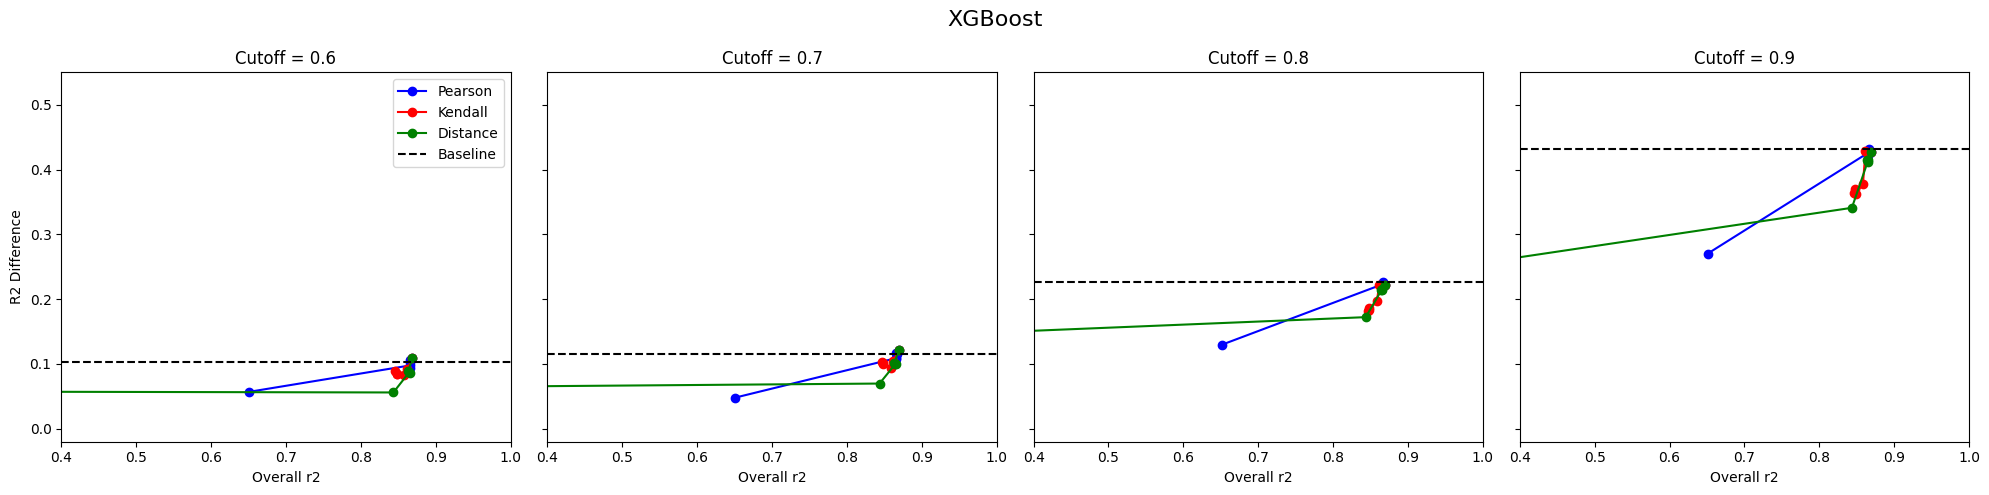

In [15]:
# xgb data plot
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
pearson_inds = (xgb_data['correction'] == 'pearson') | (xgb_data['correction'] == 'none')
kendall_inds = (xgb_data['correction'] == 'kendall') | (xgb_data['correction'] == 'none')
distance_inds = (xgb_data['correction'] == 'distance') | (xgb_data['correction'] == 'none')
inds_6 = xgb_data['cutoff'] == 0.6
inds_7 = xgb_data['cutoff'] == 0.7
inds_8 = xgb_data['cutoff'] == 0.8
inds_9 = xgb_data['cutoff'] == 0.9
ax[0].plot(xgb_data[pearson_inds & inds_6]['overall r2'], xgb_data[pearson_inds & inds_6]['r2_diff'], label='Pearson', color='blue', marker='o')
ax[1].plot(xgb_data[pearson_inds & inds_7]['overall r2'], xgb_data[pearson_inds & inds_7]['r2_diff'], color='blue', marker='o')
ax[2].plot(xgb_data[pearson_inds & inds_8]['overall r2'], xgb_data[pearson_inds & inds_8]['r2_diff'], color='blue', marker='o')
ax[3].plot(xgb_data[pearson_inds & inds_9]['overall r2'], xgb_data[pearson_inds & inds_9]['r2_diff'], color='blue', marker='o')
ax[0].plot(xgb_data[kendall_inds & inds_6]['overall r2'], xgb_data[kendall_inds & inds_6]['r2_diff'], label='Kendall', color='red', marker='o')
ax[1].plot(xgb_data[kendall_inds & inds_7]['overall r2'], xgb_data[kendall_inds & inds_7]['r2_diff'], color='red', marker='o')
ax[2].plot(xgb_data[kendall_inds & inds_8]['overall r2'], xgb_data[kendall_inds & inds_8]['r2_diff'], color='red', marker='o')
ax[3].plot(xgb_data[kendall_inds & inds_9]['overall r2'], xgb_data[kendall_inds & inds_9]['r2_diff'], color='red', marker='o')
ax[0].plot(xgb_data[distance_inds & inds_6]['overall r2'], xgb_data[distance_inds & inds_6]['r2_diff'], label='Distance', color='green', marker='o')
ax[1].plot(xgb_data[distance_inds & inds_7]['overall r2'], xgb_data[distance_inds & inds_7]['r2_diff'], color='green', marker='o')
ax[2].plot(xgb_data[distance_inds & inds_8]['overall r2'], xgb_data[distance_inds & inds_8]['r2_diff'], color='green', marker='o')
ax[3].plot(xgb_data[distance_inds & inds_9]['overall r2'], xgb_data[distance_inds & inds_9]['r2_diff'], color='green', marker='o')
# Plot dotted baseline at initial point
ax[0].axhline(y=xgb_data[inds_6]['r2_diff'].iloc[0], linestyle='--', color='black', label='Baseline')
ax[1].axhline(y=xgb_data[inds_7]['r2_diff'].iloc[0], linestyle='--', color='black')
ax[2].axhline(y=xgb_data[inds_8]['r2_diff'].iloc[0], linestyle='--', color='black')
ax[3].axhline(y=xgb_data[inds_9]['r2_diff'].iloc[0], linestyle='--', color='black')

for a in ax:
    a.set_xlabel('Overall r2')
    a.set_xlim(0.4, 1.0)
    # a.set_xscale('log')
    a.set_ylim(-0.02, 0.55)
ax[0].set_ylabel('R2 Difference')
ax[0].set_title('Cutoff = 0.6')
ax[0].legend()
ax[1].set_title('Cutoff = 0.7')
ax[2].set_title('Cutoff = 0.8')
ax[3].set_title('Cutoff = 0.9')
# Set figure title
fig.suptitle('XGBoost', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('.', 'figures', 'xgb_overall_r2.png'), dpi=300, bbox_inches='tight')
plt.show()

In [16]:
xgb_data = data[data['model'] == 'xgb']
xgb_data = xgb_data.sort_values(by=['gamma', 'cutoff'])
rf_data = data[data['model'] == 'rf']
rf_data = rf_data.sort_values(by=['gamma', 'cutoff'])
gbt_data = data[data['model'] == 'gbt']
gbt_data = gbt_data.sort_values(by=['gamma', 'cutoff'])
data_dict = {'xgb': xgb_data, 'rf': rf_data, 'gbt': gbt_data}

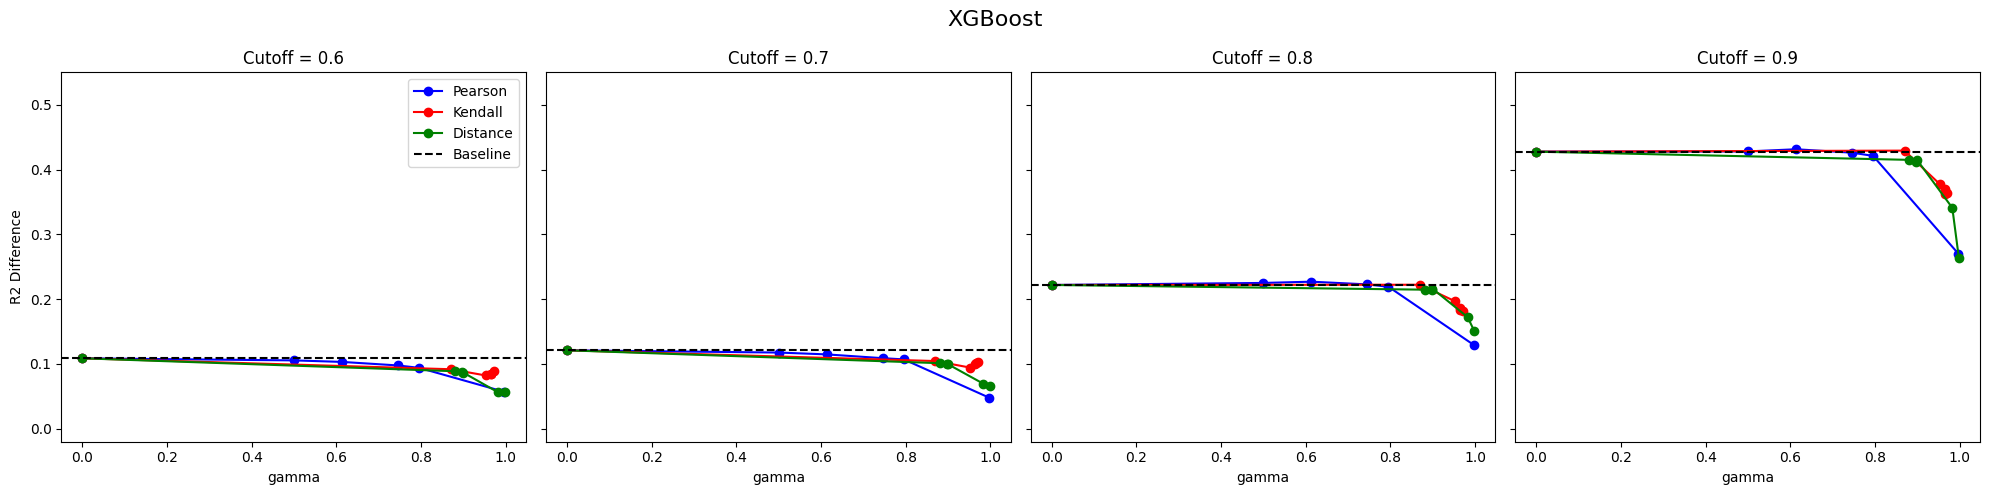

In [17]:
# xgb data plot
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
pearson_inds = (xgb_data['correction'] == 'pearson') | (xgb_data['correction'] == 'none')
kendall_inds = (xgb_data['correction'] == 'kendall') | (xgb_data['correction'] == 'none')
distance_inds = (xgb_data['correction'] == 'distance') | (xgb_data['correction'] == 'none')
inds_6 = xgb_data['cutoff'] == 0.6
inds_7 = xgb_data['cutoff'] == 0.7
inds_8 = xgb_data['cutoff'] == 0.8
inds_9 = xgb_data['cutoff'] == 0.9
ax[0].plot(xgb_data[pearson_inds & inds_6]['gamma'], xgb_data[pearson_inds & inds_6]['r2_diff'], label='Pearson', color='blue', marker='o')
ax[1].plot(xgb_data[pearson_inds & inds_7]['gamma'], xgb_data[pearson_inds & inds_7]['r2_diff'], color='blue', marker='o')
ax[2].plot(xgb_data[pearson_inds & inds_8]['gamma'], xgb_data[pearson_inds & inds_8]['r2_diff'], color='blue', marker='o')
ax[3].plot(xgb_data[pearson_inds & inds_9]['gamma'], xgb_data[pearson_inds & inds_9]['r2_diff'], color='blue', marker='o')
ax[0].plot(xgb_data[kendall_inds & inds_6]['gamma'], xgb_data[kendall_inds & inds_6]['r2_diff'], label='Kendall', color='red', marker='o')
ax[1].plot(xgb_data[kendall_inds & inds_7]['gamma'], xgb_data[kendall_inds & inds_7]['r2_diff'], color='red', marker='o')
ax[2].plot(xgb_data[kendall_inds & inds_8]['gamma'], xgb_data[kendall_inds & inds_8]['r2_diff'], color='red', marker='o')
ax[3].plot(xgb_data[kendall_inds & inds_9]['gamma'], xgb_data[kendall_inds & inds_9]['r2_diff'], color='red', marker='o')
ax[0].plot(xgb_data[distance_inds & inds_6]['gamma'], xgb_data[distance_inds & inds_6]['r2_diff'], label='Distance', color='green', marker='o')
ax[1].plot(xgb_data[distance_inds & inds_7]['gamma'], xgb_data[distance_inds & inds_7]['r2_diff'], color='green', marker='o')
ax[2].plot(xgb_data[distance_inds & inds_8]['gamma'], xgb_data[distance_inds & inds_8]['r2_diff'], color='green', marker='o')
ax[3].plot(xgb_data[distance_inds & inds_9]['gamma'], xgb_data[distance_inds & inds_9]['r2_diff'], color='green', marker='o')
# Plot dotted baseline at initial point
ax[0].axhline(y=xgb_data[inds_6]['r2_diff'].iloc[0], linestyle='--', color='black', label='Baseline')
ax[1].axhline(y=xgb_data[inds_7]['r2_diff'].iloc[0], linestyle='--', color='black')
ax[2].axhline(y=xgb_data[inds_8]['r2_diff'].iloc[0], linestyle='--', color='black')
ax[3].axhline(y=xgb_data[inds_9]['r2_diff'].iloc[0], linestyle='--', color='black')

for a in ax:
    a.set_xlabel('gamma')
    # a.set_xlim(0.4, 1.0)
    # a.set_xscale('log')
    a.set_ylim(-0.02, 0.55)
ax[0].set_ylabel('R2 Difference')
ax[0].set_title('Cutoff = 0.6')
ax[0].legend()
ax[1].set_title('Cutoff = 0.7')
ax[2].set_title('Cutoff = 0.8')
ax[3].set_title('Cutoff = 0.9')
# Set figure title
fig.suptitle('XGBoost', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('.', 'figures', 'xgb_gamma.png'), dpi=300, bbox_inches='tight')
plt.show()